In [ ]:
"""
The following code block with all the functions defined for COMBSS 
is provided by Moka et al., 2024 in their github page. 

It is based on the paper, COMBSS: best subset selection via continuous optimization, Moka et al., 2024.

I am trying to write the code from the description of their algorithms 
in the paper Moka et al., 2024. However it's still not running and there's 
some error in gradient calculation.

I am using it (from their github) to see how it performs when given the large dataset.


"""

In [54]:
# Functions for COMBSS Algorithm

import numpy as np
import pandas as pd
from numpy.linalg import inv, norm
from scipy.sparse.linalg import cg
from sklearn import metrics
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



#%%
## Function for generating the true set of model parameters. Possible beta-types are 1 and 2.
def gen_beta0(p, k0, beta_type):
    if k0 > p:
        print("Error: k0 is greater than p")
        print(sys.path)
        sys.tracebacklimit = 1
        raise ValueError()
        
    beta0 = np.zeros(p)
    if beta_type == 1:
        gap = int(p/k0)
        S0 = np.array([i*gap for i in range(k0)])  #indices of non-zero coefficients (i.e., true model)
        beta0[S0] = 1
        return beta0, S0
    
    elif beta_type == 2:
        S0 = np.arange(k0)
        beta0[S0] = 1
        return beta0, S0
    
### Function for generating covariance matrix
def cov_X(p, rho):

    cov = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            cov[i, j] = rho**(np.abs(i - j))
            
    return cov 
    
### Function for generating data
def gen_data(n, p, mean, cov, noise_var, beta0, centralize=False):

    X = np.random.multivariate_normal(mean, cov, n)
    
    if centralize:
        # centralize X
        cmean = np.mean(X, axis=0)
        X = np.subtract(X, cmean)
        if (np.sum(X) == np.zeros(p)).all(): 
            print("Error: centralization didn't work")
            print(sys.path)
            sys.tracebacklimit = 1
            raise ValueError()
            
    y = [np.random.normal(X[i]@beta0, np.sqrt(noise_var)) for i in range(n)]
    y = np.array(y)
    return [X, y]


## Functions to convert t to w and w to a t. These are important in converting the constraint problem to an unconstraint one.

def t_to_w(t):
    w = np.sqrt(-np.log(1 - t))
    return w

def w_to_t(w):
    t = 1 - np.exp(-w*w)
    return t


## Function to generate exponential grid.
def gen_lam_grid_exp(y, size, para):
    
    lam_max = norm(y)**2/(y.shape[0])  
    lam_grid = lam_max*np.array([para**i for i in range(size)])
    # lam_grid = np.append(lam_grid, 0.0)
    lam_grid = np.flip(lam_grid)
    
    return lam_grid


# Function to estimate gradient of f(t) via conjugate gradient
# Here, XX = (X.T@X)/n, Xy = (X.T@y)/n, Z = XX - (delta/n) I
#
def f_grad_cg(t, X, y, XX, Xy, Z, lam, delta, beta,  c,  g1, g2,
                cg_maxiter=None,
                cg_tol=1e-5):
    
    p = t.shape[0]
    n = y.shape[0]
    
    if n >= p:
        ## Construct Lt
        ZT = np.multiply(Z, t)
        Lt = np.multiply(ZT, t[:, np.newaxis])
        diag_Lt = np.diagonal(Lt) + (delta/n)
        np.fill_diagonal(Lt, diag_Lt)
        TXy = np.multiply(t, Xy)
        
        ## Constructing beta estimate
        beta, _ = cg(Lt, TXy, x0=beta, maxiter=cg_maxiter, tol=cg_tol)
        
        ## Constructing a and b
        gamma = t*beta
        a = -Xy
        a += XX@gamma
        b = a - (delta/n)*gamma
        
        ## Constructing c and d
        c, _ = cg(Lt, t*a, x0=c, maxiter=cg_maxiter, tol=cg_tol) 
        
        d = Z@(t*c)
        
        ## Constructing gradient
        grad = 2*(beta*(a - d) - (b*c)) + lam
        
    else:
        ## constructing Lt_tilde
        temp = 1 - t*t
        temp[temp < 1e-8] = 1e-8 
        S = n*np.divide(1, temp)/delta
        
        
        Xt = np.multiply(X, t)/np.sqrt(n)
        XtS = np.multiply(Xt, S)
        Lt_tilde = Xt@(XtS.T)
        np.fill_diagonal(Lt_tilde, np.diagonal(Lt_tilde) + 1)
        
       
        ## estimate beta
        tXy = t*Xy
        XtStXy = XtS@tXy         
        g1, _ = cg(Lt_tilde, XtStXy, x0=g1, maxiter=cg_maxiter, tol=cg_tol)
        beta = S*(tXy - Xt.T@g1)


        ## Constructing a and b
        gamma = t*beta
        a = -Xy
        a += XX@gamma
        b = a - (delta/n)*gamma
        
        ## Constructing c and d
        ta = t*a
        g2, _ = cg(Lt_tilde, XtS@ta, x0=g2, maxiter=cg_maxiter, tol=cg_tol) 
        c = S*(ta - Xt.T@g2)
        d = Z@(t*c)
        
        ## Constructing gradient
        grad = 2*(beta*(a - d) - (b*c)) + lam

    return grad, beta, c, g1, g2


## Implementation of the ADAM optimizer for best model selection.  
def ADAM_combss(X, y,  lam, t_init,
        delta_frac = 1,
        CG = True,

        ## Adam parameters
        xi1 = 0.9, 
        xi2 = 0.999,            
        alpha = 0.1, 
        epsilon = 10e-8,

        
        ## Parameters for Termination
        gd_maxiter = 1e5,
        gd_tol = 1e-5,
        max_norm = True,
        epoch=10,
        
        ## Truncation parameters
        tau = 0.5,
        eta = 0.0, 
        
        ## Parameters for Conjugate Gradient method
        cg_maxiter = None,
        cg_tol = 1e-5):
    
    """
    Proposed ADAM implimentation for the best subset selection problem. See the description in the paper.
    
    """


    (n, p) = X.shape
    
    ## One time operations
    delta = delta_frac*n
    Xy = (X.T@y)/n
    XX = (X.T@X)/n
    Z = XX.copy()
    np.fill_diagonal(Z, np.diagonal(Z) - (delta/n))
    
    ## Initialization
    t = t_init.copy()
        
    w = t_to_w(t)
    
    t_trun = t.copy()
    t_prev = t.copy()
    active = p
    
    u = np.zeros(p)
    v = np.zeros(p)
    
    beta_trun = np.zeros(p)  

    c = np.zeros(p)
    g1 = np.zeros(n)
    g2 = np.zeros(n)
    
    
    count_to_term = 0
    
    
    for l in range(gd_maxiter):
        
    
        M = np.nonzero(t)[0] ## Indices of t correponds to elements greater than eta. 
        M_trun = np.nonzero(t_trun)[0] 
        active_new = M_trun.shape[0]
        
        if active_new != active:
            ## Find the effective set by removing the columns and rows corresponds to zero t's
            XX = XX[M_trun][:, M_trun]
            Z = Z[M_trun][:, M_trun]
            X = X[:, M_trun]
            Xy = Xy[M_trun]
            active = active_new
            t_trun = t_trun[M_trun]
        
        ## Compute gradient for the effective terms
        grad_trun, beta_trun, c, g1, g2 = f_grad_cg(t_trun, X, y, XX, Xy, Z, lam, delta, beta_trun[M_trun],  c[M_trun], g1, g2)
        w_trun = w[M]
        grad_trun = 2*grad_trun*(w_trun*np.exp(- w_trun*w_trun))
        
        ## ADAM Updates
        u = xi1*u[M_trun] - (1 - xi1)*grad_trun
        v = xi2*v[M_trun] + (1 - xi2)*(grad_trun*grad_trun) 
    
        u_hat = u/(1 - xi1**(l+1))
        v_hat = v/(1 - xi2**(l+1))
        
        w_trun = w_trun + alpha*np.divide(u_hat, epsilon + np.sqrt(v_hat)) 
        w[M] = w_trun
        t[M] = w_to_t(w_trun)
        
        w[t <= eta] = 0.0
        t[t <= eta] = 0.0

     
        
        beta = np.zeros(p)
        beta[M] = beta_trun

        t_trun = t[M] 
        

        if max_norm:
            norm_t = max(np.abs(t - t_prev))
            if norm_t <= gd_tol:
                count_to_term += 1
                if count_to_term >= epoch:
                    break
            else:
                count_to_term = 0
                
        else:
            norm_t = norm(t)
            if norm_t == 0:
                break
            
            elif norm(t_prev - t)/norm_t <= gd_tol:
                count_to_term += 1
                if count_to_term >= epoch:
                    break
            else:
                count_to_term = 0
        t_prev = t.copy()
    
    model = np.where(t > tau)[0]

    if l+1 < gd_maxiter:
        converge = True
    else:
        converge = False
    return  t, model, converge, l+1

## Implementation of the Basic Gradient Descent (BGD) for best model selection.  
def BGD_combss(X, y, lam, t_init,
        delta_frac = 1,
        
        ## BGD parameters           
        alpha = 0.1, 
        epsilon = 10e-8,
        
        ## Parameters for Termination
        gd_tol = 1e-5,
        gd_maxiter = 1e5,
        max_norm = True,
        epoch = 10,
        
        ## Truncation parameters
        tau = 0.5,
        eta = 0.0, 
        
        ## Parameters for Conjugate Gradient method
        cg_maxiter = None,
        cg_tol = 1e-5):
    
    """
    Proposed ADAM implimentation for the best subset selection problem. See the description in the paper.
    
    """

    (n, p) = X.shape
    
    ## One time operations
    delta = delta_frac*n
    Xy = (X.T@y)/n
    XX = (X.T@X)/n
    Z = XX.copy()
    np.fill_diagonal(Z, np.diagonal(Z) - (delta/n))
    
    ## Initialization
    t = t_init.copy()
        
    w = t_to_w(t)
    
    t_trun = t.copy()
    t_prev = t.copy()
    active = p
    
    beta_trun = np.zeros(p)  

    c = np.zeros(p)
    g1 = np.zeros(n)
    g2 = np.zeros(n)
    
    count_to_term = 0
    
    for l in range(gd_maxiter):
        
        M = np.nonzero(t)[0] ## Indices of t correponds to elements greater than eta. 
        M_trun = np.nonzero(t_trun)[0] 
        active_new = M_trun.shape[0]
        
        if active_new != active:
            ## Find the effective set by removing the columns and rows corresponds to zero t's
            XX = XX[M_trun][:, M_trun]
            Z = Z[M_trun][:, M_trun]
            X = X[:, M_trun]
            Xy = Xy[M_trun]
            active = active_new
            t_trun = t_trun[M_trun]
        
        ## Compute gradient for the effective terms
        grad_trun, beta_trun, c, g1, g2 = f_grad_cg(t_trun, X, y, XX, Xy, Z, lam, delta, beta_trun[M_trun],  c[M_trun], g1, g2)
        w_trun = w[M]
        grad_trun = 2*grad_trun*(w_trun*np.exp(- w_trun*w_trun))
        
        ## BGD Updates
        w_trun = w_trun - alpha*grad_trun 
        w[M] = w_trun
        t[M] = w_to_t(w_trun)
        
        w[t <= eta] = 0.0
        t[t <= eta] = 0.0
        beta = np.zeros(p)
        beta[M] = beta_trun

        t_trun = t[M] 
        

        if max_norm:
            norm_temp = max(np.abs(t - t_prev))
            if norm_temp <= gd_tol:
                count_to_term += 1
                if count_to_term >= epoch:
                    break
            else:
                count_to_term = 0
                
        else:
            norm_t = norm(t)
            if norm_t == 0:
                break
            
            elif norm(t_prev - t)/norm_t <= gd_tol:
                count_to_term += 1
                if count_to_term >= epoch:
                    break
            else:
                count_to_term = 0
        t_prev = t.copy()
    
    
    model = np.where(t > tau)[0]

    if l+1 < gd_maxiter:
        converge = True
    else:
        converge = False
    return  t, model, converge, l+1



### combss implementation. 
def combss_mse(X_train, y_train, X_test, y_test, lam_grid,
            ADAM=True,  
            delta_frac = 1,
            
            ## Parameters for Termination
            gd_maxiter = 1e5,
            gd_tol = 1e-5,
            max_norm = True,
            epoch=10,
            
            ## Truncation parameters
            tau = 0.5,
            eta = 0.0, 
            
            ## Parameters for Conjugate Gradient method
            cg_maxiter = None,
            cg_tol = 0.001):
    
    
    if type(lam_grid) in (float, int):
        lam_grid = np.array([lam_grid])
    
    (n, p) = X_train.shape
    
    if cg_maxiter == None:
        cg_maxiter = n
    
    
    ## Lists for storing the outputs of GD for each lam
    mse_arr = [] # to strore mean square error for each lam
    model_list = []  # to store subset selection for each lam
    t_list = []   # to store final t selected for each lam
    t_init = np.ones(p)*0.5
    
    ## Calling COMBSS
    for i in range(lam_grid.shape[0]):
        lam = lam_grid[i]

        if ADAM:
            #t_final, s_final, converge, _ = ADAM_combss(X_train, y_train, t_init=t_init, tau=tau, delta_frac=delta_frac, lam=lam, eta=eta, epoch=epoch, gd_maxiter=gd_maxiter, gd_tol=gd_tol, cg_maxiter=cg_maxiter, cg_tol=cg_tol)
            t_final, model_final, converge, _ = ADAM_combss(X_train, y_train, lam, t_init, tau=tau, delta_frac=delta_frac, eta=eta, epoch=epoch, gd_maxiter=gd_maxiter,gd_tol=gd_tol, cg_maxiter=cg_maxiter, cg_tol=cg_tol)
        else:
            t_final, model_final, converge, _ = BGD_combss(X_train, y_train, lam, t_init=t_init, tau=tau, delta_frac=delta_frac, eta=eta, epoch=epoch, gd_maxiter=gd_maxiter, gd_tol=gd_tol, cg_maxiter=cg_maxiter, cg_tol=cg_tol)

            
        ## Computing the prediction error on the test data
        len_s = model_final.shape[0]

        if 0 < len_s < n:
            X_hat = X_train[:, model_final]
            X_hatT = X_hat.T
            
            X_hatTy = X_hatT@y_train
            XX_hat = X_hatT@X_hat
            

            beta_hat = inv(XX_hat)@X_hatTy 
            X_hat = X_test[:, model_final]
            mse = np.square(y_test - X_hat@beta_hat).mean()
        elif len_s >= n: 
            mse = 2*np.square(y_test).mean()
        else:
            mse = np.square(y_test).mean()

        mse_arr.append(mse)
        model_list.append(model_final)
        t_list.append(t_final)

    mse_arr = np.array(mse_arr) 
    return t_list, model_list, mse_arr


## Summarizes the results: a plot of lam vs mse, a plot of lam vs model size, and optimal values 
def results(beta0, X_train, y_train, lam_grid, model_list, mse_arr):
    if type(lam_grid) in (float, int):
        lam_grid = np.array([lam_grid])
        
    ind_opt = np.argmin(mse_arr)
    lam_opt = lam_grid[ind_opt]
    model_opt = model_list[ind_opt]
    len_opt = model_list[ind_opt].shape[0]
    len_arr = np.array([model.shape[0] for model in model_list])
    mse_opt = mse_arr[ind_opt]
    
    #print("True model:", np.nonzero(beta0)[0])
    print("Optimal lam:", lam_opt)
    print("Optimal model:", model_opt, "(size: %s)" %len_opt)
    print("Optimal MSE:", mse_opt)
    
    # Plotting mse and model sizes
    plt.rcParams["figure.figsize"] = (8,10)
    fig, ax = plt.subplots(2, 1)
    
    ax[0].plot(np.log(lam_grid), mse_arr, '-or')
    ax[0].set_xlabel(r'$\lambda$', fontsize=20)
    ax[0].set_ylabel('MSE (validation set)', fontsize=20)
    ax[0].plot([np.log(lam_opt), np.log(lam_opt)], [0, np.max(mse_arr)], '--b')
    ax[0].set_ylim([np.min(mse_arr)-1, np.max(mse_arr)+2])
    ax[0].tick_params(axis='x', labelsize=16)
    ax[0].tick_params(axis='y', labelsize=16)
    
    ax[1].plot(np.log(lam_grid), len_arr, '-ob')
    ax[1].set_xlabel(r'$\lambda$', fontsize=20)
    ax[1].set_ylabel('Selected model size', fontsize=20)
    ax[1].plot([np.log(lam_opt), np.log(lam_opt)], [0, np.max(len_arr)], '--b')
    ax[1].set_ylim([0, np.max(len_arr)+2])
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].tick_params(axis='x', labelsize=16)
    ax[1].tick_params(axis='y', labelsize=16)
    
    # Confusion matrix
    p = X_train.shape[1]
    beta_pred = np.zeros(p)
    
    if  len_opt > 0:
        X_hat = X_train[:, model_opt]
        X_hatT = X_hat.T
        X_hatTy = X_hatT@y_train
        XX_hat = X_hatT@X_hat
        
        beta_hat = inv(XX_hat)@X_hatTy
        beta_pred = np.zeros(p)
        beta_pred[model_opt] = beta_hat
        
    # Confusion matrix
    s_opt = np.zeros(p)
    s_opt[model_opt] = 1
    s_true = np.zeros(p)
    s_true[beta0 != 0] = 1
    cm = metrics.confusion_matrix(s_true, s_opt)
    cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=[r'$\beta = 0$',r'$\beta \neq 0$'])
    cmd.plot()
    return 

In [ ]:
"""
Load Dataset. Using the file D2XL, with 10 informative, 5 correlated and 135 noisy features.


"""

In [75]:
np.random.seed(0)

df = pd.read_csv("D2XL_Large Dataset_Train.csv")
X = df.values 
X_train = X[:,:-1]
y_train = X[:,-1]

df1 = pd.read_csv("D2XL_Large Dataset_Test.csv")
X1 = df1.values 
X_test = X1[:,:-1]
y_test = X1[:,-1]

n = X_train.shape[0]
p = X_train.shape[1]
beta_type = 1
K0 = 150
beta0, model0 = gen_beta0(p, K0, beta_type)

In [ ]:
"""
Parameters for COMBSS. 

tau maps column t to column s. Column s is the final vector giving selected columns.

eta improves speed.

"""

In [76]:
tau = 0.5
eta = 0.001

# Parameters for termination of the gradient descent
gd_tol = 0.001           # gd_tol is the tolerance of the GD method for termination.
epoch = 10               # GD terminates if the Term_cond is satisfied over epoch number of consecutive iterations.
gd_maxiter = 1000        # max number of iterations allowed by the GD method. 

In [ ]:
"""
Grid of lambda values

"""

In [71]:
lam_grid = gen_lam_grid_exp(y_train, 50, 0.8)

In [72]:
ADAM = True

In [ ]:
"""
COMBSS Algorithm over large dataset

"""

In [77]:
t_list, model_list, mse_arr = combss_mse(X_train, y_train, X_test, y_test,
                                         lam_grid, ADAM=ADAM, tau=tau, eta=eta, epoch=epoch, 
                                         gd_maxiter=gd_maxiter, gd_tol=gd_tol)

In [ ]:
"""
Final results.

The "True model" shows which columns are finally selected.
Optimal MSE is also calculated.

"""

Optimal lam: 0.019129429952749844
Optimal model: [ 0  1  2  3  4  5  6  7  8  9 10] (size: 11)
Optimal MSE: 4.162341050613969


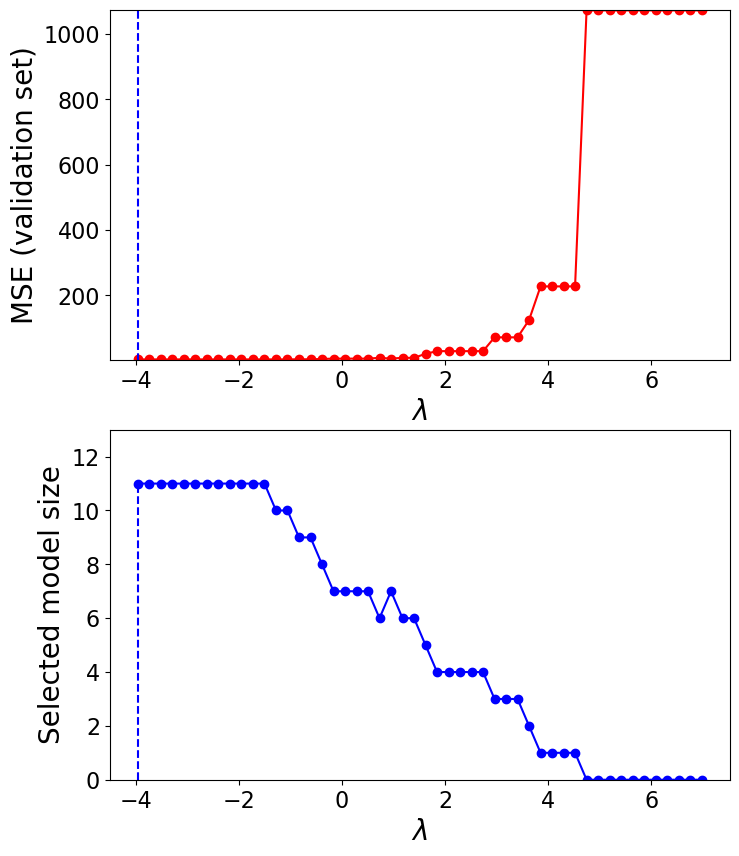

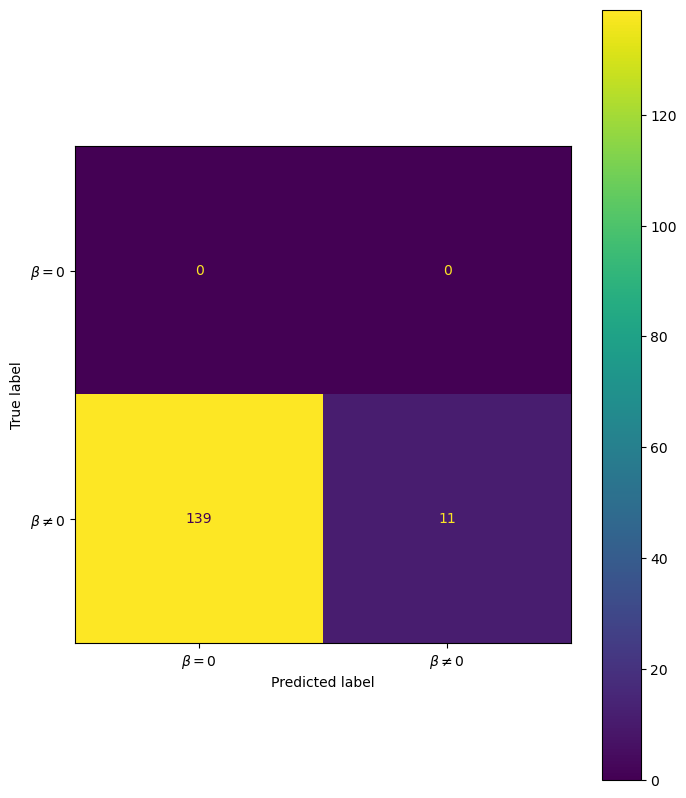

In [78]:
results(beta0, X_train, y_train, lam_grid, model_list, mse_arr)

In [ ]:
"""
From the results, it selects 9 informative columns and 2 informative column with MSE = 4.16.



"""